In [ ]:
# 1. Import thư viện
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 2) Load data (df phải có cột V1..V28, Amount, Time, Class)

df = pd.read_csv('data/creditcard.csv')
print("Kích thước dataset:", df.shape)
print(df.head())

# Lấy mẫu 10% dữ liệu để test
df = df.sample(frac=0.3, random_state=42)

print("Kích thước dữ liệu sau khi sample:", df.shape)
df.head()


Kích thước dataset: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43428,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,1
49906,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0
29474,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0
276481,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0
278846,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0


In [ ]:
# ================================================================
# 3. Train/Test split + Chuẩn hóa + SMOTE
# ================================================================
X = df.drop("Class", axis=1)
y = df["Class"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Chưa SMOTE

# Gắn lại DataFrame để giữ index & tên cột
X_train_orig = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns )

# Lưu y_train gốc để so sánh trước khi SMOTE
y_train_orig = y_train.copy()
print("Kích thước chưa SMOTE:", X_train_orig.shape, y_train_orig.shape)


Kích thước chưa SMOTE: (45494, 30) (22784,)


In [ ]:
# SMOTE để cân bằng dữ liệu
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

print("Kích thước sau SMOTE:", X_train.shape, y_train.shape)


Kích thước sau SMOTE: (45494, 30) (45494,)


# Reshape cho CNN

In [ ]:
X_train_cnn = X_train_smote.reshape(X_train_smote.shape[0], X_train_smote.shape[1],1)
X_test_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print("Shape X_train_cnn :", X_train_cnn.shape)
print("Shape X_test_cnn :", X_test_cnn.shape)

In [ ]:

# ================================================================
# 4. Hàm train với RandomizedSearchCV
# ================================================================
import matplotlib.pyplot as plt

from sklearn.metrics import (
    average_precision_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)

def run_model(name, model, param_dist, n_iter=5, cv=3):
    """
    Huấn luyện model với RandomizedSearchCV và in kết quả đánh giá.
    Trả về: search object, best model
    """
    print(f"\n▶️ Đang train {name} ...")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring="average_precision",
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # Dự đoán
    y_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # Đánh giá
    ap = average_precision_score(y_test, y_proba)
    print(f"\n{name} - Best Params: {search.best_params_}")
    print(f"{name} - CV Best Score: {search.best_score_:.4f}")
    print(f"{name} - Test AP Score: {ap:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.4f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

    # PR Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"{name} (AP={ap:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.legend()
    plt.show()

    return search, best_model


In [ ]:
# 4. Hyperparam distributions (rút gọn)
# ================================================================
param_dist_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
}

param_dist_xgb = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5],
    "learning_rate": [0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "tree_method": ["hist"],
}

param_dist_mlp = {
    "hidden_layer_sizes": [(50,), (100,)],
    "activation": ["relu", "tanh"],
    "solver": ["adam"],
    "alpha": [0.0001, 0.001],
    "learning_rate_init": [0.001, 0.01],
}



▶️ Đang train RandomForest ...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

RandomForest - Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': None}
RandomForest - CV Best Score: 1.0000
RandomForest - Test AP Score: 0.2458
Confusion Matrix:
 [[5688    0]
 [   9    0]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9984    1.0000    0.9992      5688
           1     0.0000    0.0000    0.0000         9

    accuracy                         0.9984      5697
   macro avg     0.4992    0.5000    0.4996      5697
weighted avg     0.9968    0.9984    0.9976      5697



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

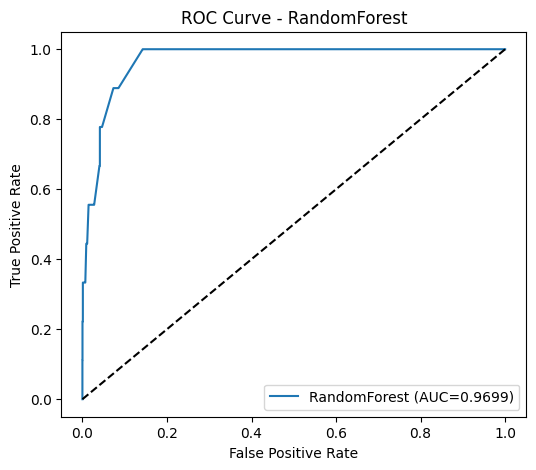

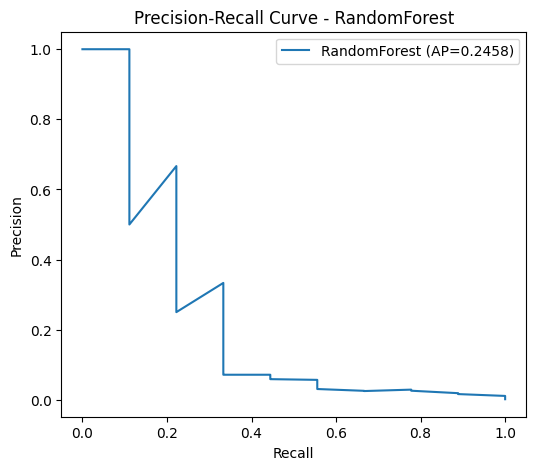


▶️ Đang train XGBoost ...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

XGBoost - Best Params: {'tree_method': 'hist', 'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
XGBoost - CV Best Score: 1.0000
XGBoost - Test AP Score: 0.3497
Confusion Matrix:
 [[5688    0]
 [   8    1]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9986    1.0000    0.9993      5688
           1     1.0000    0.1111    0.2000         9

    accuracy                         0.9986      5697
   macro avg     0.9993    0.5556    0.5996      5697
weighted avg     0.9986    0.9986    0.9980      5697



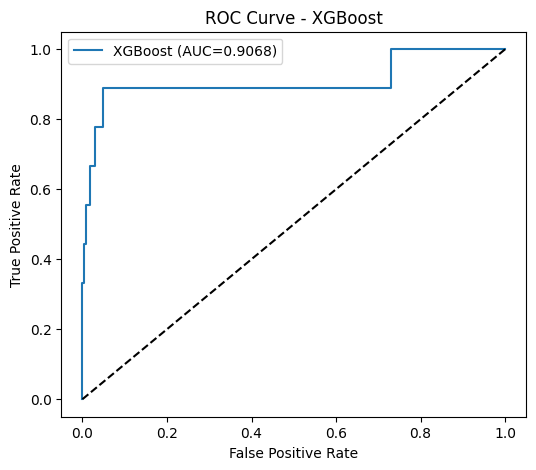

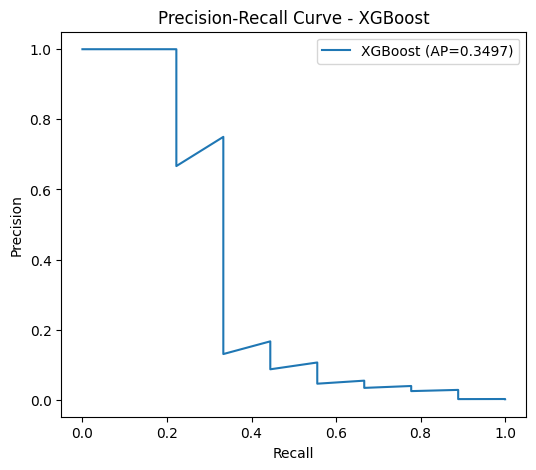


▶️ Đang train NeuralNetwork ...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

NeuralNetwork - Best Params: {'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'tanh'}
NeuralNetwork - CV Best Score: 1.0000
NeuralNetwork - Test AP Score: 0.3912
Confusion Matrix:
 [[5688    0]
 [   9    0]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9984    1.0000    0.9992      5688
           1     0.0000    0.0000    0.0000         9

    accuracy                         0.9984      5697
   macro avg     0.4992    0.5000    0.4996      5697
weighted avg     0.9968    0.9984    0.9976      5697



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

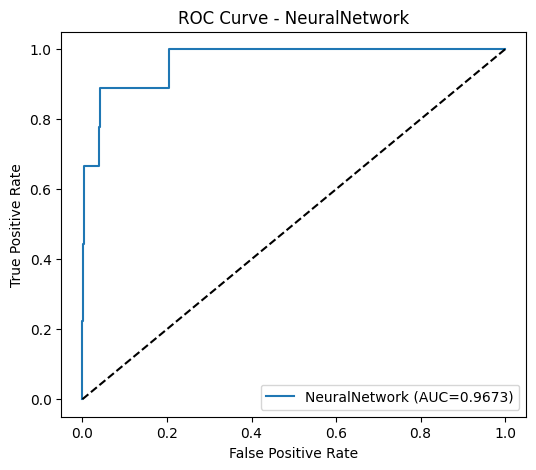

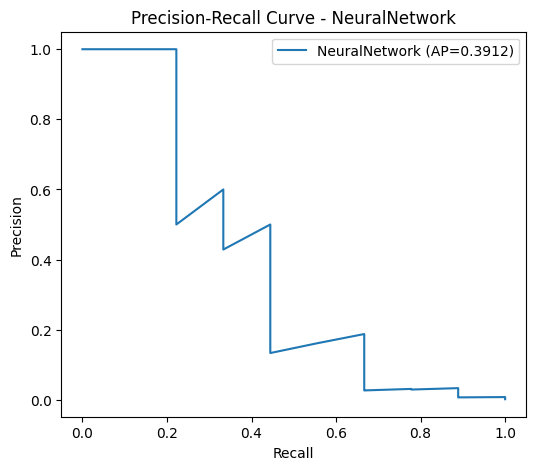

In [ ]:
# ================================================================
# 6. Train RandomForest, XGBoost, Neural Network
# ================================================================
rf_search, rf_model = run_model(
    "RandomForest",
    RandomForestClassifier(random_state=4),
    param_dist_rf,
    n_iter=5
)

xgb_search, xgb_model = run_model(
    "XGBoost",
    XGBClassifier(random_state=42, eval_metric="logloss"),
    param_dist_xgb,
    n_iter=5
)

nn_search, nn_model = run_model(
    "NeuralNetwork",
    MLPClassifier(random_state=42, max_iter=300),
    param_dist_mlp,
    n_iter=5
)


CNN Model

In [ ]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001,
                  loss='binary_crossentropy',           metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

cnn_model = build_cnn_model(X_train_cnn.shape[1], 1))

early_stop = EarlyStopping(monitor='val_loss',
patience=5, restore_best_weights=True)

history = cnn_model.fit(
    X_train_cnn, y_train_smote,
    epochs=20,
    batch_size=128,
    validation_spit=0.2,
    callbacks=[early_stop],
    verbose=1
)

cnn_model.save('cnn_fraud_model.h5')
print("CNN trainning hoàn tất.")


In [ ]:
# Visualize training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


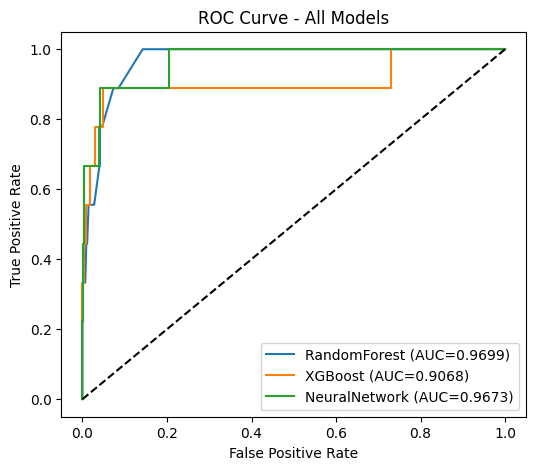

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


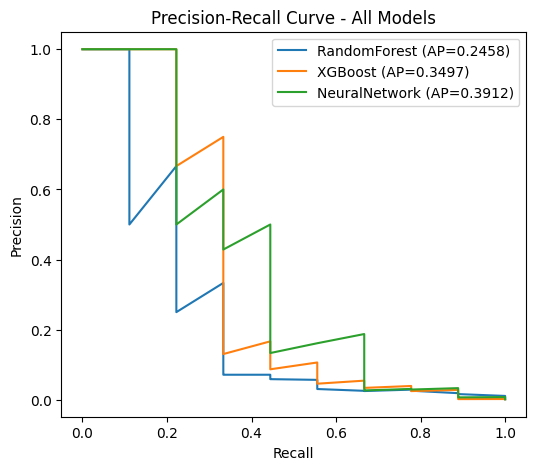

In [ ]:
# ================================================================
# 7. So sánh chung ROC + PR
# ================================================================
results = [
    ("RandomForest", rf_model),
    ("XGBoost", xgb_model),
    ("NeuralNetwork", nn_model)
]

# ROC chung
plt.figure(figsize=(6,5))
for name, model in results:
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.4f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - All Models")
plt.legend()
plt.show()

# PR chung
plt.figure(figsize=(6,5))
for name, model in results:
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - All Models")
plt.legend()
plt.show()


In [ ]:
# 7. Tổng hợp kết quả
# ================================================================
# 7. Đánh giá mô hình trên tập test
# ================================================================
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(f"\n===== {name} =====")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")

# Gọi đánh giá cho 3 mô hình
evaluate_model("RandomForest", rf_model)
evaluate_model("XGBoost", xgb_model)
evaluate_model("Neural Network", nn_model)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resul


===== RandomForest =====
Confusion Matrix:
[[5688    0]
 [   9    0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9984    1.0000    0.9992      5688
           1     0.0000    0.0000    0.0000         9

    accuracy                         0.9984      5697
   macro avg     0.4992    0.5000    0.4996      5697
weighted avg     0.9968    0.9984    0.9976      5697

ROC AUC: 0.9699
Average Precision: 0.2458

===== XGBoost =====
Confusion Matrix:
[[5688    0]
 [   8    1]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9986    1.0000    0.9993      5688
           1     1.0000    0.1111    0.2000         9

    accuracy                         0.9986      5697
   macro avg     0.9993    0.5556    0.5996      5697
weighted avg     0.9986    0.9986    0.9980      5697

ROC AUC: 0.9068
Average Precision: 0.3497

===== Neural Network =====
Confusion Matrix:
[[5688    0]
 [   9    0]]

Cla

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


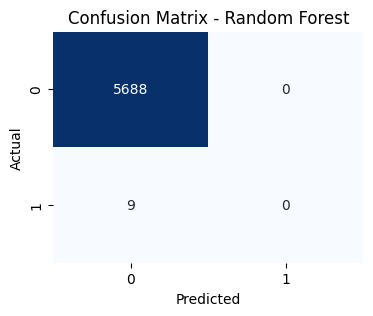

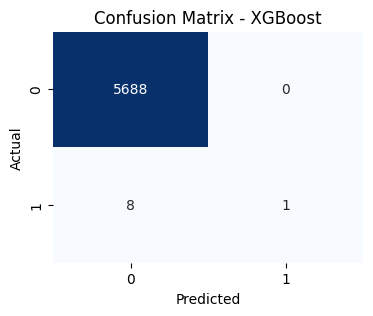

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


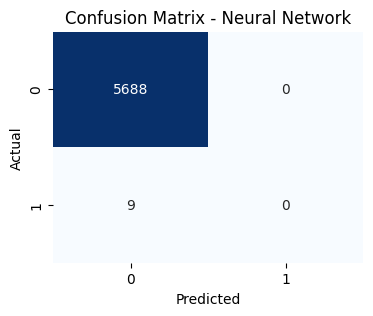

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "Neural Network": nn_model
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


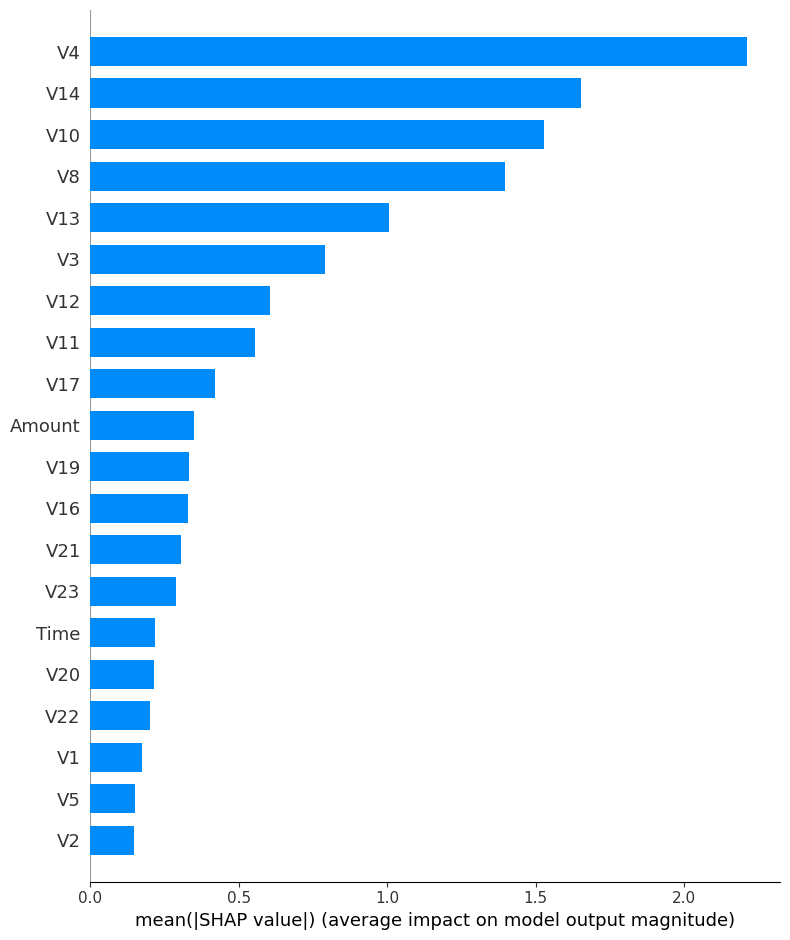

In [ ]:
import shap

# Dùng SHAP cho XGBoost (hỗ trợ tốt nhất)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Vẽ summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [ ]:
# ================================================================\
# Đánh giá CNN
# ================================================================

y_pred_cnn_prob = cnn_model.predict(X_test_cnn, verbose=0)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int).flatten()

print("\n===== CNN Results =====")
print(classification_report(y_test, y_pred_cnn, target_names=['Not Fraud', 'Fraud']))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_cnn_prob))
print("PR-AUC:", average_precision_score(y_test, y_pred_cnn_prob))

# Confusion Matrix (tùy chọn visualize)
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
print("Confusion Matrix:\n", cm_cnn)

In [ ]:
# ================================================================
# 8. Gradio UI - Dùng models đã train ở Cell 5
# ================================================================
import gradio as gr
import numpy as np
import pandas as pd

# Gom models vào dict
models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "MLP Neural": nn_model,
    "CNN": cnn_model
}

# === Hàm predict ===
def predict_fraud(amount, v, model, threshold=0.5):
    try:
        features = v + [amount]
        sample = pd.DataFrame([features], columns=feature_cols)
        sample_scaled = scaler.transform(sample)
        if isinstance(model, tf.keras.Model):
            sample_scaled = sample_scaled.reshape(1, sample_scaled.shape[1], 1)
            prob = model.predict(sample_scaled, verbose=0)[0][0]
        else:
            prob = model.predict_proba(sample_scaled)[:, 1][0]
        pred = int(prob >= threshold)
        return {
            "amount": float(amount),
            "probability": float(prob),
            "threshold": threshold,
            "prediction": "🚨 FRAUD" if pred == 1 else "✅ NOT FRAUD"
        }
    except Exception as e:
        return {"error": str(e)}

# === Hàm nhập tay ===
def parse_and_predict(amount, features_str, model_name, threshold=0.5):
    try:
        v = list(map(float, features_str.split(",")))
        if len(v) != 28:
            return {"error": f"Cần nhập đúng 28 giá trị V1–V28, hiện tại có {len(v)}"}
        return predict_fraud(amount, v, models[model_name], threshold)
    except Exception as e:
        return {"error": str(e)}

# === Hàm sample ngẫu nhiên ===
def random_sample_predict(model_name, threshold=0.5):
    idx = np.random.randint(len(X_test))
    sample = X_test.iloc[idx]
    amount = sample["Amount"]
    v = sample.drop("Amount").tolist()
    result = predict_fraud(amount, v, models[model_name], threshold)
    result["sample_features"] = v
    return result

# === Gradio UI ===
with gr.Blocks() as demo:
    gr.Markdown("## 💳 Credit Card Fraud Detection (RF + XGB + MLP)")
    gr.Markdown("Bạn có thể nhập thủ công hoặc test bằng sample ngẫu nhiên")

    with gr.Row():
        amount_in = gr.Number(label="Transaction Amount", value=100)
        features_in = gr.Textbox(
            label="V1–V28 (comma-separated)",
            placeholder="-1.2,0.5,0.3,..."
        )
        thresh_in = gr.Number(label="Decision Threshold", value=0.5)
        model_in = gr.Dropdown(list(models.keys()), label="Chọn model", value="Random Forest")

    with gr.Row():
        btn_predict = gr.Button("🔍 Predict từ input")
        btn_random = gr.Button("🎲 Sample ngẫu nhiên từ tập test")

    output = gr.JSON(label="Kết quả dự đoán")

    btn_predict.click(parse_and_predict, inputs=[amount_in, features_in, model_in, thresh_in], outputs=output)
    btn_random.click(random_sample_predict, inputs=[model_in, thresh_in], outputs=output)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7fe25798bea1fd7f3c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
